# Adaptive Curriculum for the Hole in Wall Task

In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import scriptinit
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
from matplotlib.pyplot import *
from pyrl.algorithms.uvfa import *
from pyrl.algorithms.valueiter import *
from pyrl.tasks.gridworld import *
from pyrl.algorithms.nn import *
from pyrl.agents.agent import *
from pyrl.agents.multitask import *
from pyrl.algorithms.multitask import *
import pyrl.agents.arch as arch
from pyrl.prob import *
from pyrl.utils import *
from pyrl.evaluate import *

In [6]:
def showV(v):
    imshow(v.reshape(H, W), interpolation='none')
    plt.axis('off')
#     print v
    
def showExperience(agent):
    task_types = set(agent.experience_task)
    task_percent = dict()
    for task in task_types:
        task_percent[task] = sum([e == task for e in agent.experience_task])
#     total = sum(task_percent.values())
    total = 1.
    return {key: val / float(total) for (key, val) in task_percent.items()}

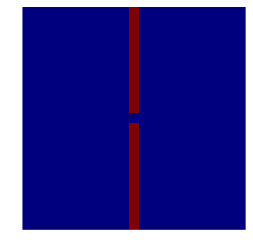

In [7]:
# world 1
H = W = 21
world = np.zeros((H, W))
world[:10, 10] = 1
world[11:, 10] = 1
showV(world)

# Sanity Checks

Start with a few sub-tasks, and see if the strategies (like Gaussian Process) are working.

In [33]:
two_layer_arch = lambda states: arch.two_layer(states, H * W * 2, 32, 4)
grid = Grid(world, action_stoch=0.2)
tol = 1e-6

In [46]:
goal = {(20, 20): 1.}
max_steps = 2.
gamma = tol ** (1. / max_steps)
tasks = [GridWorldUltimateFixedStart(grid.state_id[(19,20)], grid_env=grid, goal=goal, demons={}, rewards=goal, wall_penalty=0., gamma=gamma),
         GridWorldUltimateFixedStart(grid.state_id[(20,19)], grid_env=grid, goal=goal, demons={}, rewards=goal, wall_penalty=0., gamma=gamma),
         GridWorldUltimateFixedStart(grid.state_id[(19,19)], grid_env=grid, goal=goal, demons={}, rewards=goal, wall_penalty=0., gamma=gamma),
         GridWorldUltimateFixedStart(grid.state_id[(12,12)], grid_env=grid, goal=goal, demons={}, rewards=goal, wall_penalty=0., gamma=gamma),
         GridWorldUltimateFixedStart(grid.state_id[(0,0)], grid_env=grid, goal=goal, demons={}, rewards=goal, wall_penalty=0., gamma=gamma),
         ]
         

In [48]:
def run_on_task(task):
    dqn = DQN(task, two_layer_arch)
    learner = DeepQlearn(task, dqn, lr=1e-4, memory_size=250)
    performance = []
    for it in range(20):
        learner.run(budget = 100)
        performance.append(reward_tabular_normalized_fix_start(dqn, task, tol=1e-4))
#         performance.append(reward_stochastic(dqn, task, num_trials=1000, tol=1e-4))
#         print performance[-1]
    plot(performance)

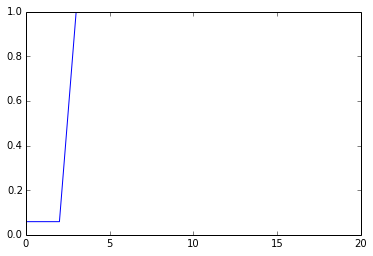

In [49]:
run_on_task(tasks[0])

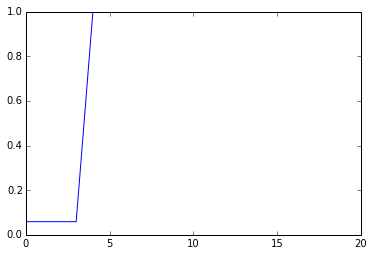

In [50]:
run_on_task(tasks[1])

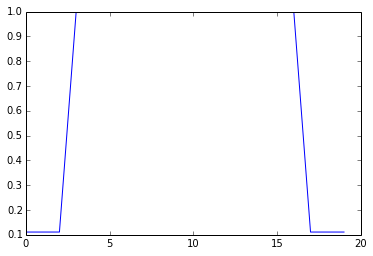

In [51]:
run_on_task(tasks[2])

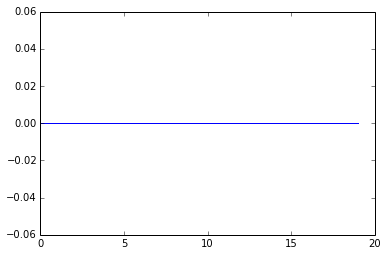

In [52]:
run_on_task(tasks[3])

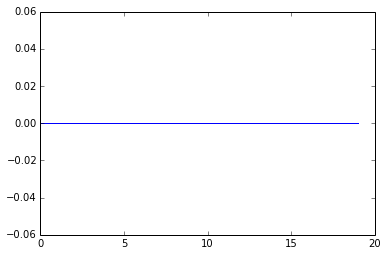

In [53]:
run_on_task(tasks[4])

# Non-Stationary MAB

Use the expected performance gain to measure the progress in MAB.

In [243]:
class SingleLearnerMAB(object):
    def __init__(self, dqn, tasks, mab_gamma, mab_scale, mab_batch_size, **kwargs):
        self.dqn = dqn
        self.tasks = tasks
        self.log_weights = [0. for task in tasks]
        self.mab_gamma = mab_gamma
        self.mab_batch_size = mab_batch_size
        self.mab_scale = mab_scale
        self.deepQlearn = DeepQlearn(tasks[0], dqn, **kwargs)
        self.cumulative_epochs = 0
        self.last_task = 0
        self.last_performance = 0.
        self.last_perfomances = []
        self.last_progress = 0.
        for ti, task in enumerate(self.tasks):
            self.last_performance += reward_tabular_normalized_fix_start(self.dqn, task, tol=1e-4)
        print 'initial performance', self.last_performance

    def run(self, num_epochs=1, budget=100):
        num_tasks = len(self.tasks)
        for epoch in range(num_epochs):
            # choose task based on weights.
            taski = -1
            if npr.rand() < self.mab_gamma / num_tasks:
                taski = npr.choice(range(num_tasks), 1)[0]
            else:
                p = np.exp(prob.normalize_log(self.log_weights))
                taski = npr.choice(range(num_tasks), 1, replace=True, p=p)[0]
                
            task = self.tasks[taski]
            self.last_task = taski

            # (TODO) this breaks away the abstraction.
            self.deepQlearn.task = task
            self.dqn.task = task

            # run training.
            self.deepQlearn.run(budget = budget)

            # update weights.
            self.cumulative_epochs += 1
            if self.cumulative_epochs >= self.mab_batch_size:
                self.log_weights[:] = 0.
            else:
                performance = 0.
                self.last_performances = []
                for ti, task in enumerate(self.tasks):
                    self.last_performances.append(reward_tabular_normalized_fix_start(self.dqn, task, tol=1e-4))
                    performance += self.last_performances[-1]
                progress = performance - self.last_performance
                self.last_performance = performance
                self.last_progress = progress
                self.log_weights[taski] += self.mab_gamma * self.mab_scale * progress / num_tasks
                for ti in range(num_tasks):
                    self.log_weights[ti] -= 10.
                self.log_weights = normalize_log(self.log_weights)


In [244]:
dqn = DQN(tasks[0], two_layer_arch)
learner = SingleLearnerMAB(dqn, tasks, mab_gamma = 0.2, mab_scale = 30., mab_batch_size = 10000)

initial performance 0.713875546719


In [245]:
for it in range(30):
    learner.run(num_epochs=1, budget=100)
    print 'task', learner.last_task
    print 'progress', learner.last_progress
    print 'performance', learner.last_performances
    print 'performance', learner.last_performance
    print np.exp(normalize_log(learner.log_weights))
    print learner.log_weights
    print 

task 3
progress 0.0
performance [0.19140215072524716, 0.40935212580489022, 0.11312127018895113, 0.0, 0.0]
performance 0.713875546719
[ 0.2  0.2  0.2  0.2  0.2]
[-1.60943791 -1.60943791 -1.60943791 -1.60943791 -1.60943791]

task 4
progress 0.305859268169
performance [0.30034356940453777, 0.49842132360864461, 0.2209699218747436, 0.0, 0.0]
performance 1.01973481489
[ 0.18370727  0.18370727  0.18370727  0.18370727  0.26517094]
[-1.69441174 -1.69441174 -1.69441174 -1.69441174 -1.32738061]

task 3
progress 0.0467604807917
performance [0.31694587268809832, 0.51387271054798789, 0.23567671244357147, 0.0, 0.0]
performance 1.06649529568
[ 0.18177986  0.18177986  0.18177986  0.1922716   0.26238883]
[-1.70495891 -1.70495891 -1.70495891 -1.64884633 -1.33792778]

task 4
progress -0.016826654074
performance [0.29751869814862614, 0.52526699263515197, 0.22688295082190901, 0.0, 0.0]
performance 1.04966864161
[ 0.18273832  0.18273832  0.18273832  0.19328538  0.25849965]
[-1.69970008 -1.69970008 -1.6997000

**Note** 
* Try use eps-greedy policy during test time, this turns out to be very unstable. performance could easily oscillate between 0 and 1.
* Use weight decay instead of reseting the weights every MAB batch.

# Log-Linear Model

In [292]:
class SingleLearnerLogLinear(object):
    def __init__(self, dqn, tasks, mab_gamma, mab_scale, mab_batch_size, **kwargs):
        self.dqn = dqn
        self.tasks = tasks
        self.log_weights = [0. for task in tasks]
        self.deepQlearn = DeepQlearn(tasks[0], dqn, **kwargs)
        self.last_task = 0
        self.last_performance = 0.
        self.last_performances = {}
        self.performance_history = {}
        self.last_progress = 0.
        self.feat_last_progress = {}
        for ti, task in enumerate(self.tasks):
            self.last_performance += reward_tabular_normalized_fix_start(self.dqn, task, tol=1e-4)
            self.performance_history[ti] = []
        print 'initial performance', self.last_performance

    def run(self, num_epochs=1, budget=100):
        num_tasks = len(self.tasks)
        for epoch in range(num_epochs):
            # choose task based on weights.
            taski = -1
            p = np.exp(prob.normalize_log(self.log_weights))
            taski = npr.choice(range(num_tasks), 1, replace=True, p=p)[0]
                
            task = self.tasks[taski]
            self.last_task = taski

            # (TODO) this breaks away the abstraction.
            self.deepQlearn.task = task
            self.dqn.task = task

            # run training.
            self.deepQlearn.run(budget = budget)

            # update weights.
            performance = 0.
            self.last_performances = {}
            for ti, task in enumerate(self.tasks):
                self.last_performances[ti] = reward_tabular_normalized_fix_start(self.dqn, task, tol=1e-4)
                self.performance_history[ti].append(self.last_performances[ti])
                performance += self.last_performances[ti]
            progress = performance - self.last_performance
            self.feat_last_progress[taski] = progress
            self.last_performance = performance
            self.last_progress = progress
            
            for ti in range(num_tasks):
                self.log_weights[ti] = 0.
                self.log_weights[ti] += 30 * self.feat_last_progress[ti] if ti in self.feat_last_progress else 0.
                self.log_weights[ti] -= 100 if ti in self.last_performances and self.last_performances[ti] > 0.9 else 0.



In [293]:
dqn = DQN(tasks[0], two_layer_arch)
learner = SingleLearnerLogLinear(dqn, tasks, mab_gamma = 0.2, mab_scale = 30., mab_batch_size = 10000)

initial performance 0.124182675601


In [294]:
for it in range(30):
    learner.run(num_epochs=1, budget=100)
    print 'task', learner.last_task
    print 'progress', learner.last_progress
    print 'performance', learner.last_performances
    print 'performance', learner.last_performance
    print np.exp(normalize_log(learner.log_weights))
    print learner.log_weights
    print 

task 3
progress 0.0
performance {0: 0.058823526911092931, 1: 0.058823529263916256, 2: 0.006535619425906098, 3: 0.0, 4: 0.0}
performance 0.124182675601
[ 0.2  0.2  0.2  0.2  0.2]
[0.0, 0.0, 0.0, 0.0, 0.0]

task 0
progress 1.04584345536
performance {0: 0.99999995999733382, 1: 0.058870628235133254, 2: 0.11115554272825844, 3: 0.0, 4: 0.0}
performance 1.17002613096
[  3.93199599e-31   2.50000000e-01   2.50000000e-01   2.50000000e-01
   2.50000000e-01]
[-68.624696339205684, 0.0, 0.0, 0.0, 0.0]

task 1
progress 1.82997365368
performance {0: 0.99999995999533542, 1: 0.99999995999533386, 2: 0.99999986464746937, 3: 0.0, 4: 0.0}
performance 2.99999978464
[  7.86399198e-31   1.29403377e-20   1.86003799e-44   5.00000000e-01
   5.00000000e-01]
[-68.624696339205684, -45.100790389677606, -100.0, 0.0, 0.0]

task 4
progress -0.888888693028
performance {0: 0.99999991999333881, 1: 0.99999995999534053, 2: 0.11111121162169252, 3: 0.0, 4: 0.0}
performance 2.11111109161
[  7.86399198e-31   1.29403377e-20   5.0

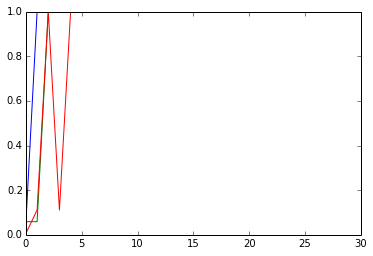

In [297]:
figure()
for ti in range(len(tasks)):
    plot(learner.performance_history[ti])

In this tiny example, we have shown that for easier tasks (shorter horizon and closer distance to goal), the model is able to predict and identify those tasks. This allows the model to create a curriculum automatically from this pool of tasks.